<a href="https://colab.research.google.com/github/Yeniffer-tareasmgds/Tarea1-DPyP/blob/tarea1-branch1/00_de_nyc_taxi_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de Propinas para Viajes en Taxi en NYC (2020)

Inspirado en la charla ["Keeping up with Machine Learning in Production"](https://github.com/shreyashankar/debugging-ml-talk) de [Shreya Shankar](https://twitter.com/sh_reya)


Este notebook muestra la construcción de un modelo de machine learning de juguete, usando datos de viajes de los taxis amarillos de Nueva York para el año 2020, [proporcionados por la NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

La idea es encontrar aquellos viajes donde la propina dejada por el pasajero fue alta, es decir, mayor al 20% del costo del viaje.

Para ello ajustaremos un modelo de classificación binaria RandomForest usando los datos de los viajes de enero de 2020. Probaremos el modelo resultante sobre los datos de los viajes de febrero de 2020. Compararemos el desempeño del modelo en ambos casos usando la métrica de [f1-score](https://en.wikipedia.org/wiki/F-score).

**Este notebook está construido para ser ejecutado en [Google Colab](https://colab.research.google.com/), al que podemos acceder de manera gratuita solo teniendo un usuario de Google (Gmail) y un navegador web. No es necesario instalar nada en el computador local.**

## Cargando las librerías necesarias

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Leemos los datos de enero 2020 (entrenamiento)

In [2]:
taxi = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet')

In [3]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [4]:
taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

## Definimos las características con las que realizaremos la clasificación.

Las construiremos a continuación en la etapa de pre-procesamiento de los datos.

In [5]:
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

In [6]:
def preprocess(df, target_col):

   # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)


In [7]:
target_col = "high_tip"

taxi_train = preprocess(df=taxi, target_col=target_col)

In [8]:
print(f'Num rows: {len(taxi_train)}, Size: {taxi_train.memory_usage(deep=True).sum() / 1e9} GB')

Num rows: 6382762, Size: 0.3574348 GB


## Ajustamos el modelo con los datos de entrenamiento

Este proceso se puede demorar bastante (¡en mi caso fueron 30 minutos!), pero podemos realizar una prueba mas pequeña reduciendo la cantidad de ejemplos de entrenamiento. Por ejemplo podríamos agregar la siguiente celda:

`taxi_train = taxi_train.head(100000)`

In [9]:
%%time

rfc = RandomForestClassifier(n_estimators=100, max_depth=10)

rfc.fit(taxi_train[features], taxi_train[target_col])

CPU times: user 19min 9s, sys: 15.8 s, total: 19min 24s
Wall time: 19min 35s


RandomForestClassifier(max_depth=10)

## Calculamos la métrica f1-score en el conjunto de entrenamiento

In [10]:
%%time
# Compute F1

preds = rfc.predict_proba(taxi_train[features])

CPU times: user 1min 1s, sys: 2.07 s, total: 1min 3s
Wall time: 1min 3s


In [11]:
preds_labels = [p[1] for p in preds.round()]

In [12]:
print(f'F1: {f1_score(taxi_train[target_col], preds_labels)}')

F1: 0.7296052347992907


## Exportamos el modelo a un archivo

In [13]:
import joblib

joblib.dump(rfc, "./random_forest.joblib")

['./random_forest.joblib']

El archivo aparecerá en el menú del lado izquierdo, como se muestra en la foto. Podemos guardarlo en nuestro equipo usando boton derecho -> Download. Será útil hacerlo porque lo seguiremos usando en el futuro.

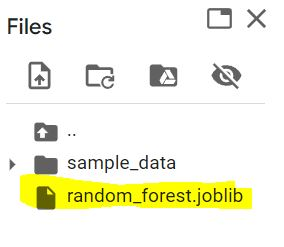

## Cargamos los datos de febrero 2020 (prueba)

In [14]:
taxi_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet')
taxi_test = preprocess(taxi_feb, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-02-01 00:30:32,5.0,0.0,0.0,17.0,1.0,2.60,777.0,0.003346,145.0,7.0,1.0,1
1,2020-02-01 01:05:36,5.0,0.0,0.0,32.0,1.0,4.80,1969.0,0.002438,45.0,61.0,1.0,1
2,2020-02-01 00:43:28,5.0,0.0,0.0,31.0,1.0,3.20,704.0,0.004545,186.0,140.0,1.0,0
3,2020-02-01 00:31:39,5.0,0.0,0.0,7.0,1.0,4.38,1444.0,0.003033,144.0,140.0,1.0,0
4,2020-02-01 01:01:29,5.0,0.0,0.0,51.0,1.0,2.28,586.0,0.003891,238.0,152.0,1.0,0


## Cargamos el modelo que guardamos y realizamos predicciones de prueba

In [15]:
loaded_rfc = joblib.load("./random_forest.joblib")

In [16]:
%%time
# Compute F1
# This is (relatively) slow since we are copying data to the CPU to compute the metric.

preds_test = loaded_rfc.predict_proba(taxi_test[features])

CPU times: user 1min 1s, sys: 2.09 s, total: 1min 3s
Wall time: 1min 4s


In [17]:
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

F1: 0.7348499501315856


## Intentemos realizar la predicción de un solo viaje

Necesitaremos hacer algo así más adelante

In [18]:
taxi_test.head(1)[features].iloc[0].values

array([5.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7000000e+01,
       1.0000000e+00, 2.5999999e+00, 7.7700000e+02, 3.3462034e-03,
       1.4500000e+02, 7.0000000e+00, 1.0000000e+00], dtype=float32)

In [19]:
taxi_test.head(1)[target_col].iloc[0]

1

In [20]:
loaded_rfc.predict_proba(taxi_test.head(1)[features].iloc[0].values.reshape(1, -1))[0][1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.5239207186548788

## Motivación: calculemos el desempeño para mayo de 2020

In [21]:
taxi_may= pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet')
taxi_test = preprocess(taxi_may, target_col=target_col)
print(taxi_test.head(5))

preds_test = loaded_rfc.predict_proba(taxi_test[features])
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')


  tpep_dropoff_datetime  pickup_weekday  pickup_hour  work_hours  \
0   2020-04-01 01:01:53             2.0          0.0         0.0   
1   2020-04-01 01:09:25             2.0          0.0         0.0   
2   2020-04-01 00:09:25             2.0          0.0         0.0   
3   2020-04-01 00:34:38             2.0          0.0         0.0   
4   2020-04-01 00:18:26             2.0          0.0         0.0   

   pickup_minute  passenger_count  trip_distance  trip_time  trip_speed  \
0           41.0              1.0           1.20     1231.0    0.000975   
1           56.0              1.0           3.40      805.0    0.004224   
2            0.0              1.0           2.80      539.0    0.005195   
3           24.0              0.0           2.60      600.0    0.004333   
4           13.0              1.0           1.44      302.0    0.004768   

   PULocationID  DOLocationID  RatecodeID  high_tip  
0          41.0          24.0         1.0         0  
1          95.0         197.0   

## Desempeño mensual (2020-01 al 2020-05)

In [22]:
import matplotlib.pyplot as plt

In [23]:
# Definimos los meses a revisar y creamos lista para los puntajes
months = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05']
f1_scores = []

In [24]:
# Bucle para procesar cada mes
for month in months:
    # Carga de datos:
    data_url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{month}.parquet'
    taxi_data = pd.read_parquet(data_url)

    # Preprocesamiento de datos:
    taxi_test = preprocess(taxi_data, target_col=target_col)

    # Predicciones:
    preds_test = loaded_rfc.predict_proba(taxi_test[features])

    # Etiquetas de predicciones:
    preds_test_labels = [p[1] for p in preds_test.round()]

    # F1 score:
    f1 = f1_score(taxi_test[target_col], preds_test_labels)
    f1_scores.append(f1)
    print(f'F1 score for {month}: {f1}')


F1 score for 2020-01: 0.7296052347992907
F1 score for 2020-02: 0.7348499501315856
F1 score for 2020-03: 0.7256196581831836
F1 score for 2020-04: 0.61123054060683
F1 score for 2020-05: 0.615969746669016


In [25]:
# Creamos DF para los resultados y graficammos
f1_df = pd.DataFrame({'Month': months,'F1 Score': f1_scores})

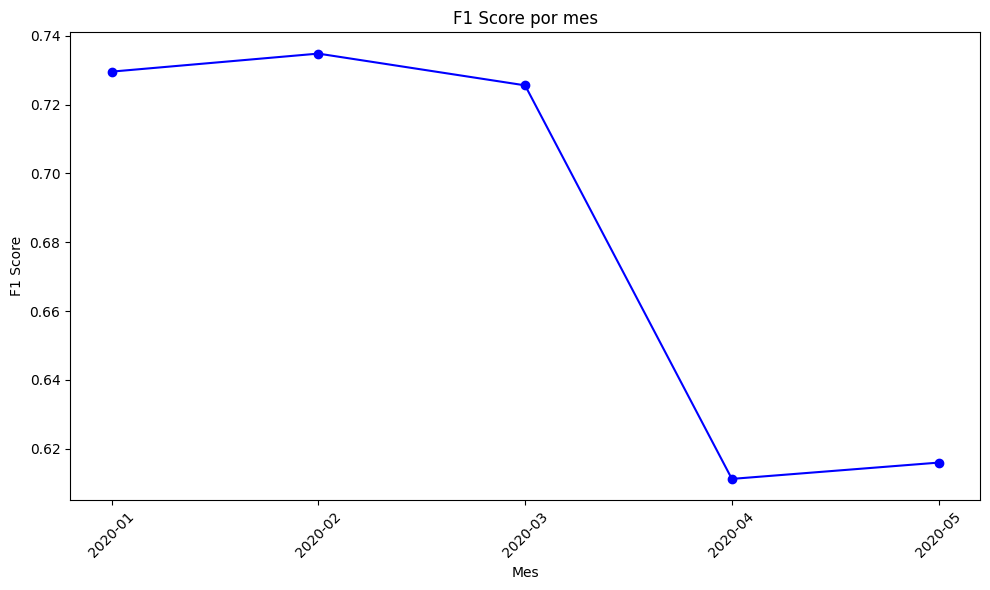

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(f1_df['Month'], f1_df['F1 Score'], marker='o', linestyle='-', color='b')
plt.title('F1 Score por mes')
plt.xlabel('Mes')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Estrategia a usar para explicar/demostrar el comportamiento distinto del modelo para cada mes del análisis

Para demostrar el distinto comportamiento del modelo en los meses del análisis se revisarán otras metricas como precisión, recall y accuracy, de esta manera podremos ver las diferencias por mes. Además se analizarán las caracteristicas que influyen en el modelo.  

Primero análizamos las métricas y la importancia de las características del modelo:

In [27]:
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [28]:
months = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05']
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
feature_importances = {}

In [29]:
for month in months:
    # Cargar los datos del mes
    data_url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{month}.parquet'
    taxi_data = pd.read_parquet(data_url)

    # Preprocesamiento y predicciones
    taxi_test = preprocess(taxi_data, target_col=target_col)
    preds_test = loaded_rfc.predict_proba(taxi_test[features])
    preds_test_labels = [p[1] for p in preds_test.round()]

    # Métricas
    f1 = f1_score(taxi_test[target_col], preds_test_labels)
    precision = precision_score(taxi_test[target_col], preds_test_labels)
    recall = recall_score(taxi_test[target_col], preds_test_labels)
    accuracy = accuracy_score(taxi_test[target_col], preds_test_labels)

    # Almacenar las métricas
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

    # Importancia de características
    if month == months[0]:
        feature_importances = loaded_rfc.feature_importances_

    print(f'{month} - F1: {f1}, Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}')


2020-01 - F1: 0.7296052347992907, Precision: 0.5899671658305401, Recall: 0.9558412626439077, Accuracy: 0.600004042137244
2020-02 - F1: 0.7348499501315856, Precision: 0.5963233818103788, Recall: 0.9572111348827028, Accuracy: 0.6038209587159428
2020-03 - F1: 0.7256196581831836, Precision: 0.5869995149210794, Recall: 0.9499508993796556, Accuracy: 0.5994530868941499
2020-04 - F1: 0.61123054060683, Precision: 0.4782007506278748, Recall: 0.846800387771215, Accuracy: 0.5444675015109187
2020-05 - F1: 0.615969746669016, Precision: 0.47897519351085177, Recall: 0.8627220193030549, Accuracy: 0.5912922807058036


In [30]:
metrics_df = pd.DataFrame({'Month': months,'F1 Score': f1_scores,'Precision': precision_scores,'Recall': recall_scores,'Accuracy': accuracy_scores})

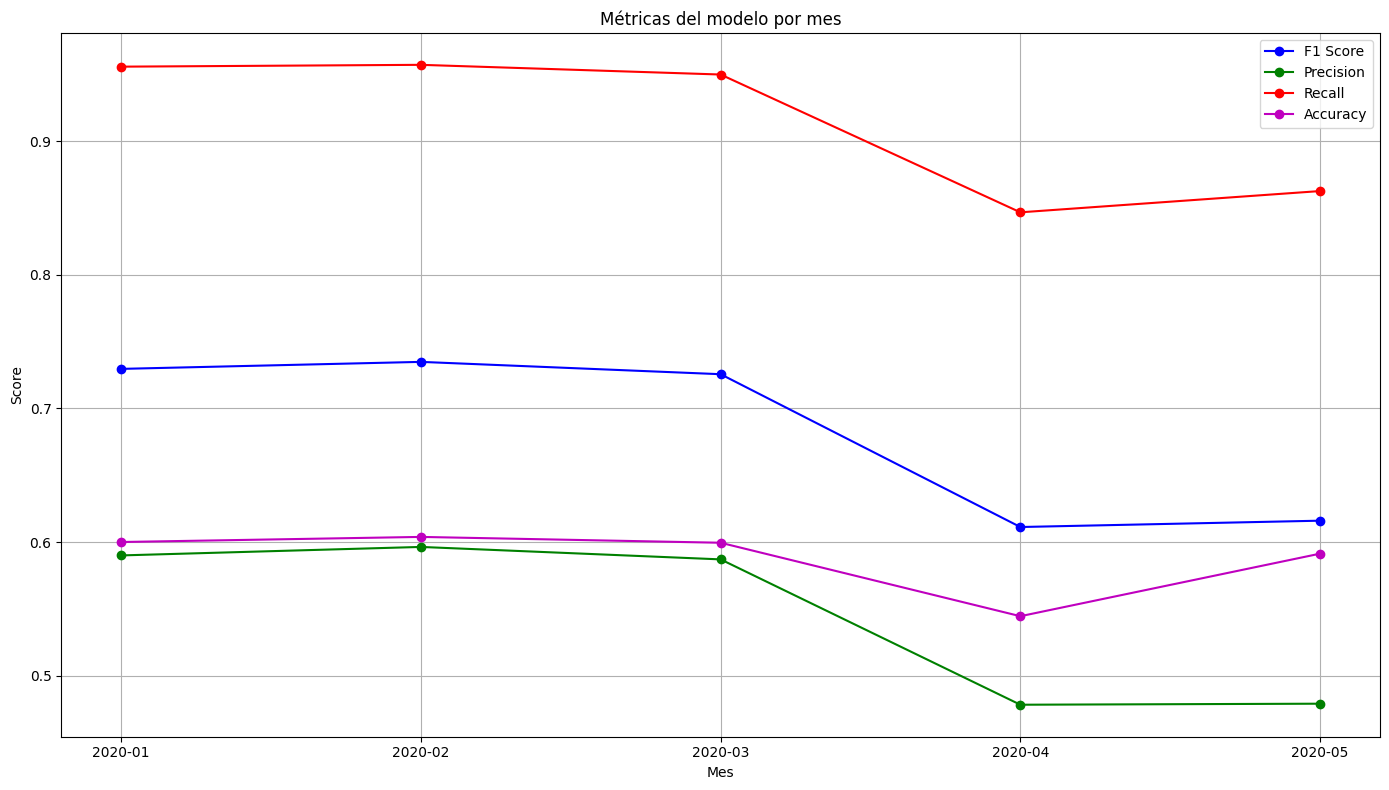

In [31]:
# Graficar las métricas por mes
plt.figure(figsize=(14, 8))
plt.plot(metrics_df['Month'], metrics_df['F1 Score'], marker='o', linestyle='-', label='F1 Score', color='b')
plt.plot(metrics_df['Month'], metrics_df['Precision'], marker='o', linestyle='-', label='Precision', color='g')
plt.plot(metrics_df['Month'], metrics_df['Recall'], marker='o', linestyle='-', label='Recall', color='r')
plt.plot(metrics_df['Month'], metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy', color='m')
plt.title('Métricas del modelo por mes')
plt.xlabel('Mes')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


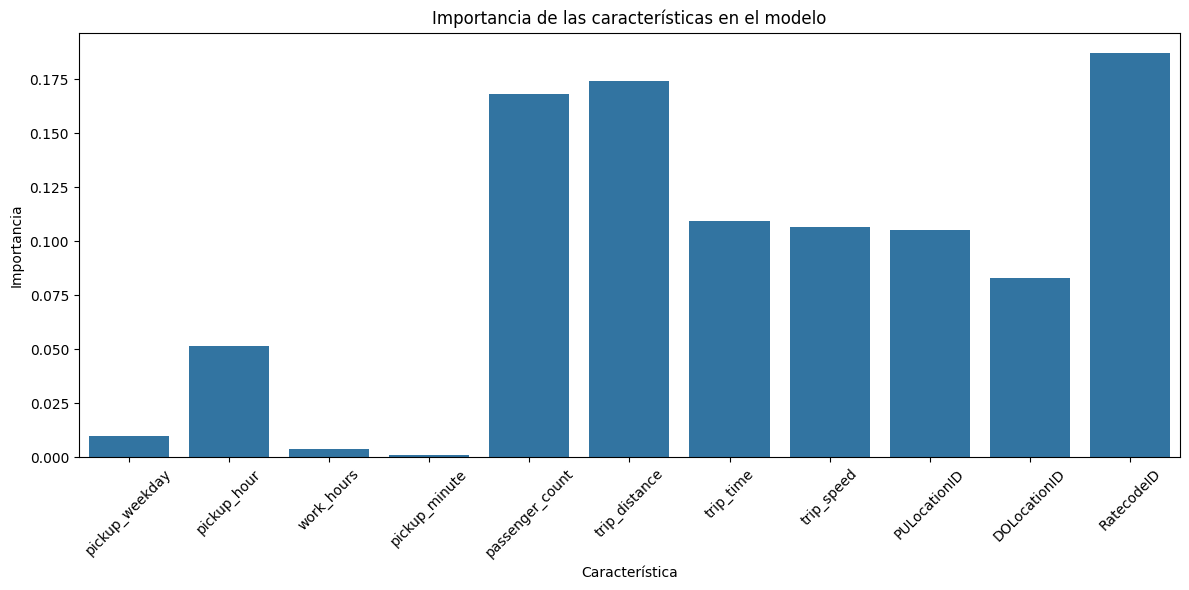

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x=features, y=feature_importances)
plt.title('Importancia de las características en el modelo')
plt.xlabel('Característica')
plt.ylabel('Importancia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Resultados Métricas:** Se puede observar una caída de todas las métricas luego del mes de marzo, principalmente en el mes de abril, individualmente se puede observar que en mayo la métrica accuracy se recupera nuevamente, F1 score y Recall cuentan con una ligera recuperación, mientras que precisión recae constantemente. Además se puede observar una garn diferencia entre Recall y precisión indicando que posiblemente el modelo tiene dificultades para identificar correctamente instancias positivas luego de marzo, posiblemente debido a los cambios en el comportamiento de los usuarios/datos.

**Resultados Características:**  Las 3 características más importantes del modelo son RatecodeID, trip_distance, y passenger_count, riendo RatecodeID la característica más influyente, indicando la importancia del código tarifario para el modelo, le sigue la distancia recorrida por el taxi y la cantidadde pasajeros.

Luego, análizamos las 3 características más importantes del modelo

In [33]:
top_features = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)[:3]


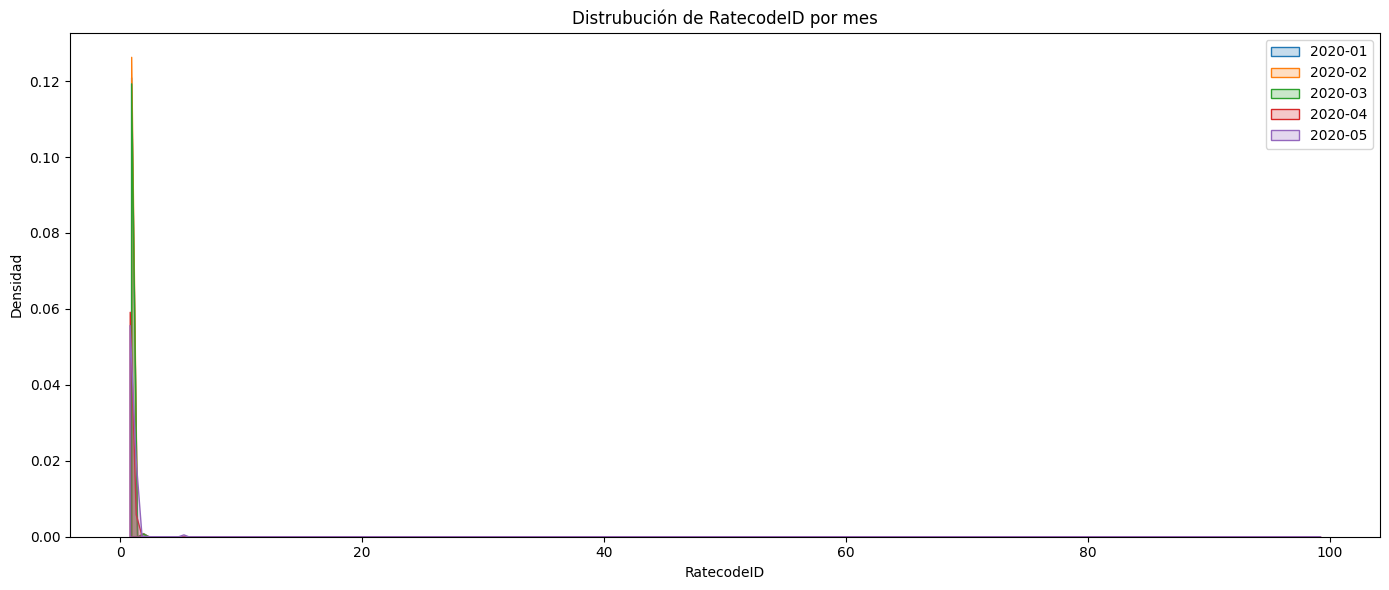

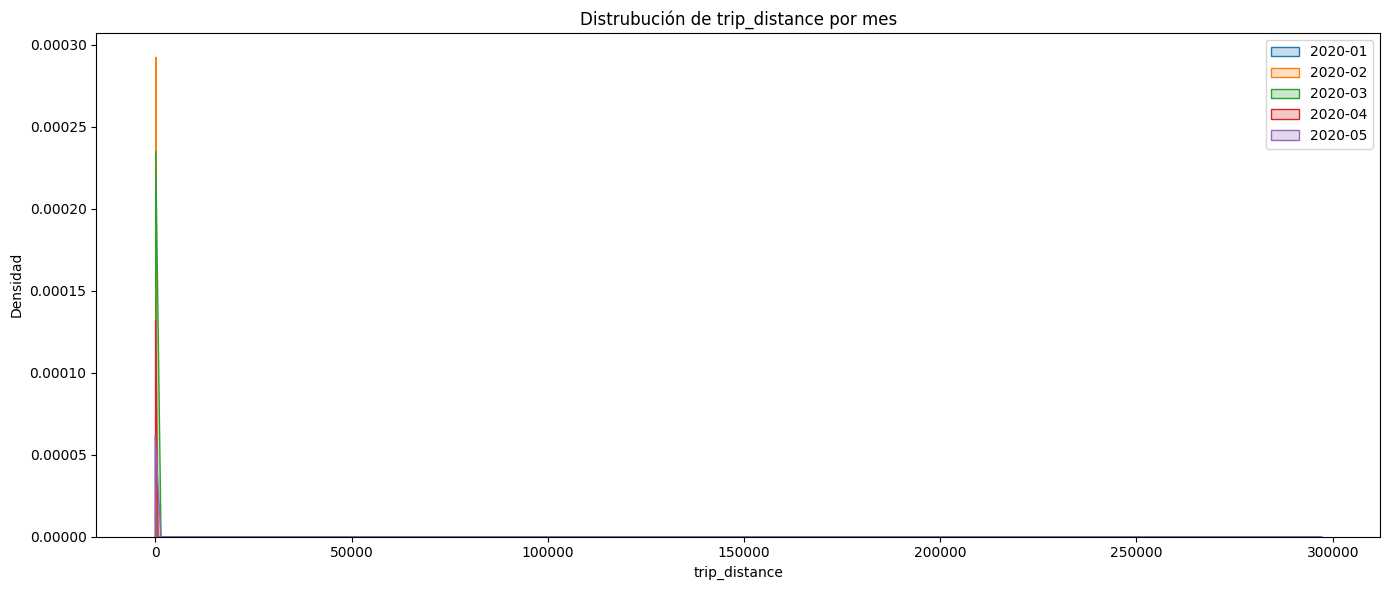

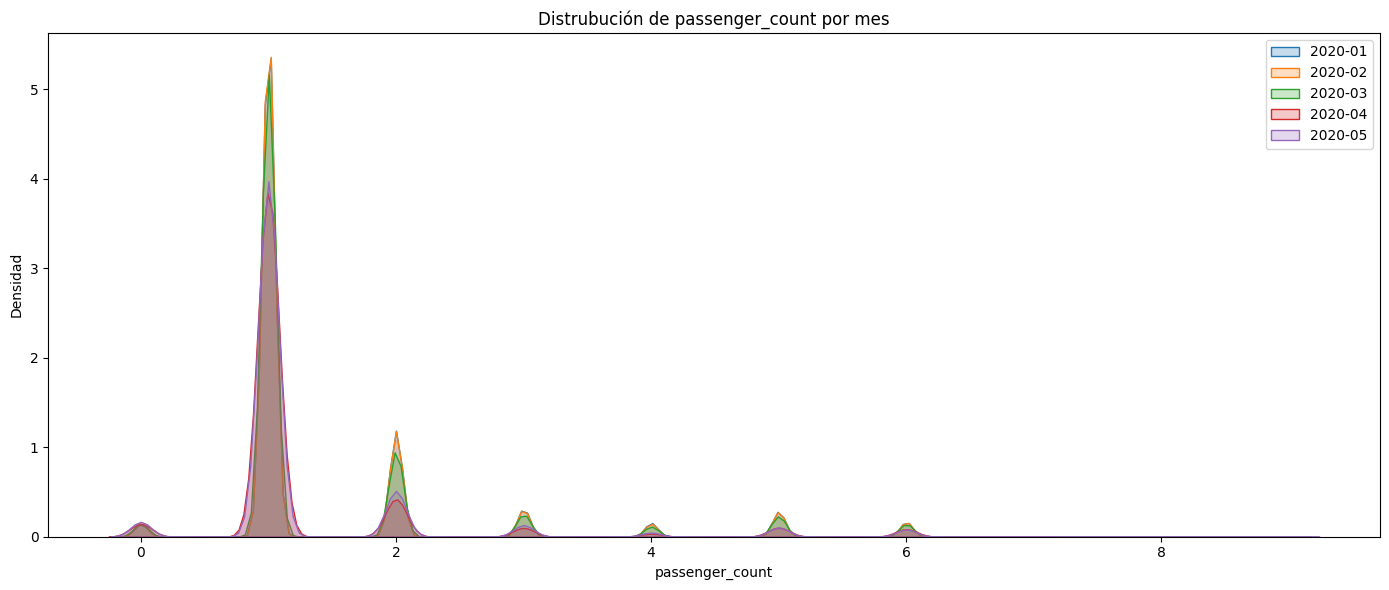

In [34]:
# Identificar características que están disponibles en los datos de todos los meses
available_features = []

for feature, _ in top_features:
    is_available = True
    for month in months:
        data_url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{month}.parquet'
        taxi_data = pd.read_parquet(data_url)
        if feature not in taxi_data.columns:
            is_available = False
            print(f"{feature}' no encontrada en {month}.")
            break
    if is_available:
        available_features.append(feature)

# Grafico (solo si esta en todos los meses)
for feature in available_features:
    plt.figure(figsize=(14, 6))
    for month in months:
        data_url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{month}.parquet'
        taxi_data = pd.read_parquet(data_url)
        sns.kdeplot(taxi_data[feature], label=f'{month}', fill=True)
    plt.title(f'Distrubución de {feature} por mes')
    plt.xlabel(feature)
    plt.ylabel('Densidad')
    plt.legend()
    plt.tight_layout()
    plt.show()

**Resultado distribución características importantes:**  


*   RatecodeID: se puede observar una distribución concentrada principalmente en 1 o tarifa estandar, luego le sigue 2 o tarfifa al aeropuerto JFK.
*   trip_distance: Las distancias recorridas por los taxis tienen cortas distancias, más cercanas al kilometro, sin embargo, se ven valore atipicos extremadamente altos, siendo posiblemente un error o una anomalía.
* passenger_count: La mayoria de los viajes cuentan con solo un pasajero.

En general se puede observar en general una caída en la densidad de los meses abril y mayo.



### Conclusión.

Con la estrategía de análisis realizada podemos observar como las métricas del modelo variaron mes a mes principalmente cuando observamos una drastica caída del rendimiento en el mes abril, el cual, puede ser atribuible al inicio de la pandemia Covid-19 que afecto mundialmente a la movilidad de las personas y por ende la utilización del transporte en taxis en la ciudad de New York. Adicionalmente se observaron las caracteristicas más importantes en el análisis como RateCodeID, trip_distance y passenger_count, con la intención de conocer mejor el modelo y como podía estar afectanto al comportamiento mensual, en ellos también podemos observar una caída en la densidad generacional durante el inicio del encierro a fines de marzo afectando principalmente en la caída de abril, tambien se puede observar la drástica caida de transporte a los aeropuertos por los cierres de frontera. Por ende, debido a factores externos, el modelo no tuvo buen redimiento debido al cambio del comportamiento de los usuarios de taxis.

#### Anexos

In [ ]:
import pandas as pd


months = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05']

ratecode_df = pd.DataFrame()

for month in months:
    data_url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{month}.parquet'
    taxi_data = pd.read_parquet(data_url)
    taxi_data['Month'] = month
    ratecode_df = pd.concat([ratecode_df, taxi_data[['Month', 'RatecodeID']]])

ratecode_distribution = ratecode_df.groupby(['Month', 'RatecodeID']).size().reset_index(name='Count')
ratecode_distribution = ratecode_distribution.sort_values(by=['RatecodeID', 'Month'])
ratecode_distribution_list = ratecode_distribution.values.tolist()
ratecode_distribution_list


[['2020-01', 1.0, 6126536],
 ['2020-02', 1.0, 6057436],
 ['2020-03', 1.0, 2886847],
 ['2020-04', 1.0, 216093],
 ['2020-05', 1.0, 285373],
 ['2020-01', 2.0, 157733],
 ['2020-02', 2.0, 140831],
 ['2020-03', 2.0, 58968],
 ['2020-04', 2.0, 1025],
 ['2020-05', 2.0, 1859],
 ['2020-01', 3.0, 13476],
 ['2020-02', 3.0, 12735],
 ['2020-03', 3.0, 5854],
 ['2020-04', 3.0, 158],
 ['2020-05', 3.0, 319],
 ['2020-01', 4.0, 5130],
 ['2020-02', 4.0, 4649],
 ['2020-03', 4.0, 2228],
 ['2020-04', 4.0, 175],
 ['2020-05', 4.0, 238],
 ['2020-01', 5.0, 36296],
 ['2020-02', 5.0, 34541],
 ['2020-03', 5.0, 15847],
 ['2020-04', 5.0, 1025],
 ['2020-05', 5.0, 1694],
 ['2020-01', 6.0, 46],
 ['2020-02', 6.0, 28],
 ['2020-03', 6.0, 15],
 ['2020-04', 6.0, 2],
 ['2020-05', 6.0, 6],
 ['2020-01', 99.0, 350],
 ['2020-02', 99.0, 313],
 ['2020-03', 99.0, 120],
 ['2020-04', 99.0, 15],
 ['2020-05', 99.0, 25]]

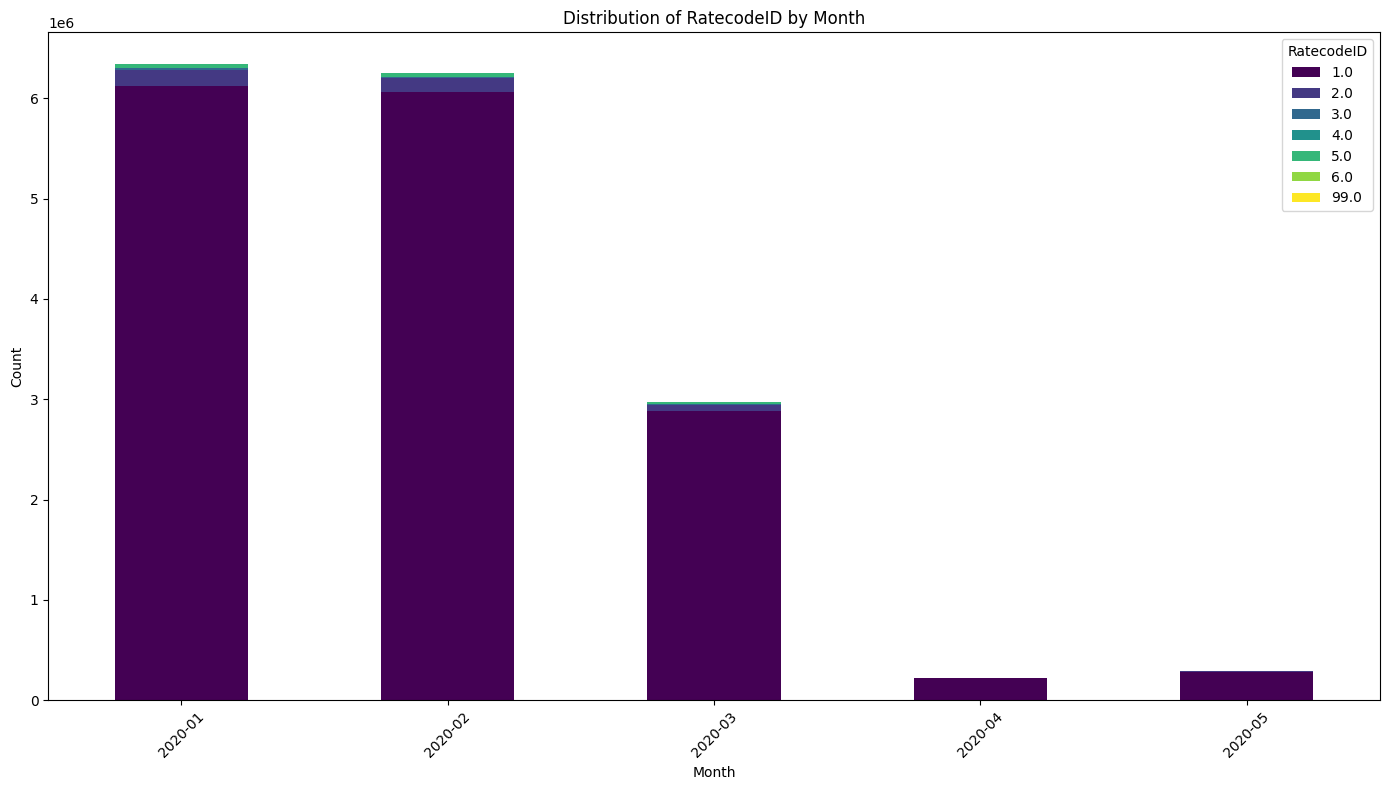

In [37]:
months = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05']

ratecode_df = pd.DataFrame()
for month in months:
    data_url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{month}.parquet'
    taxi_data = pd.read_parquet(data_url)
    taxi_data['Month'] = month
    ratecode_df = pd.concat([ratecode_df, taxi_data[['Month', 'RatecodeID']]])

ratecode_pivot = ratecode_df.pivot_table(index='Month', columns='RatecodeID', aggfunc='size', fill_value=0)

ratecode_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')

plt.title('Distribution of RatecodeID by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='RatecodeID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#probando

probando